##### Import library

In [1]:
import kaos
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
import itertools
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

2024-04-12 20:51:27.158433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True):

    """
    Customize the appearance of matplotlib axis for a figure.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.

    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """

    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=90)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax

##### Define kmer length

In [3]:
kmer_length = 8

##### Read DNA sequence

In [4]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.
# sequences

##### Read corresponding label

In [5]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

##### One hot encode the labels

In [6]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

##### Divide the data in X, y

In [8]:
X = list()

chaos_game_kmer_array = kaos.chaos_game_representation_key(kmer_length=kmer_length)

for i in range(len(sequences)):
    # print(i)
    X.append(kaos.chaos_frequency_matrix(sequences[i], kmer_length= kmer_length, chaos_game_kmer_array=chaos_game_kmer_array)[0])

In [9]:
y = input_labels.copy()

##### Divide the data in train (75%) and test (25%)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.25, random_state=42)

##### Define model architecture

In [22]:
import tensorflow as tf
from keras.layers import Dense, LeakyReLU
from keras.initializers import he_normal
model = Sequential()
model.add(Conv1D(filters=32, activation= "LeakyReLU", kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation= "LeakyReLU"))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 254, 32)           24608     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 127, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4064)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                260160    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 284,898
Trainable params: 284,898
Non-trainable params: 0
________________________________________________

##### Train the model

In [23]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.25, batch_size=1500)

Epoch 1/100
1/1 [==============================] - 1s 922ms/step - loss: 0.7586 - accuracy: 0.5031 - val_loss: 10.7323 - val_accuracy: 0.5200
Epoch 2/100
1/1 [==============================] - 0s 255ms/step - loss: 11.2513 - accuracy: 0.4969 - val_loss: 0.8148 - val_accuracy: 0.4800
Epoch 3/100
1/1 [==============================] - 0s 256ms/step - loss: 0.7905 - accuracy: 0.5031 - val_loss: 2.4795 - val_accuracy: 0.4800
Epoch 4/100
1/1 [==============================] - 0s 267ms/step - loss: 2.3669 - accuracy: 0.5031 - val_loss: 0.8202 - val_accuracy: 0.4800
Epoch 5/100
1/1 [==============================] - 0s 264ms/step - loss: 0.7967 - accuracy: 0.5031 - val_loss: 0.8414 - val_accuracy: 0.5200
Epoch 6/100
1/1 [==============================] - 0s 284ms/step - loss: 0.8710 - accuracy: 0.4969 - val_loss: 0.9542 - val_accuracy: 0.5200
Epoch 7/100
1/1 [==============================] - 0s 242ms/step - loss: 0.9930 - accuracy: 0.4969 - val_loss: 0.7613 - val_accuracy: 0.5200
Epoch 8/100

##### Plot all the required curve

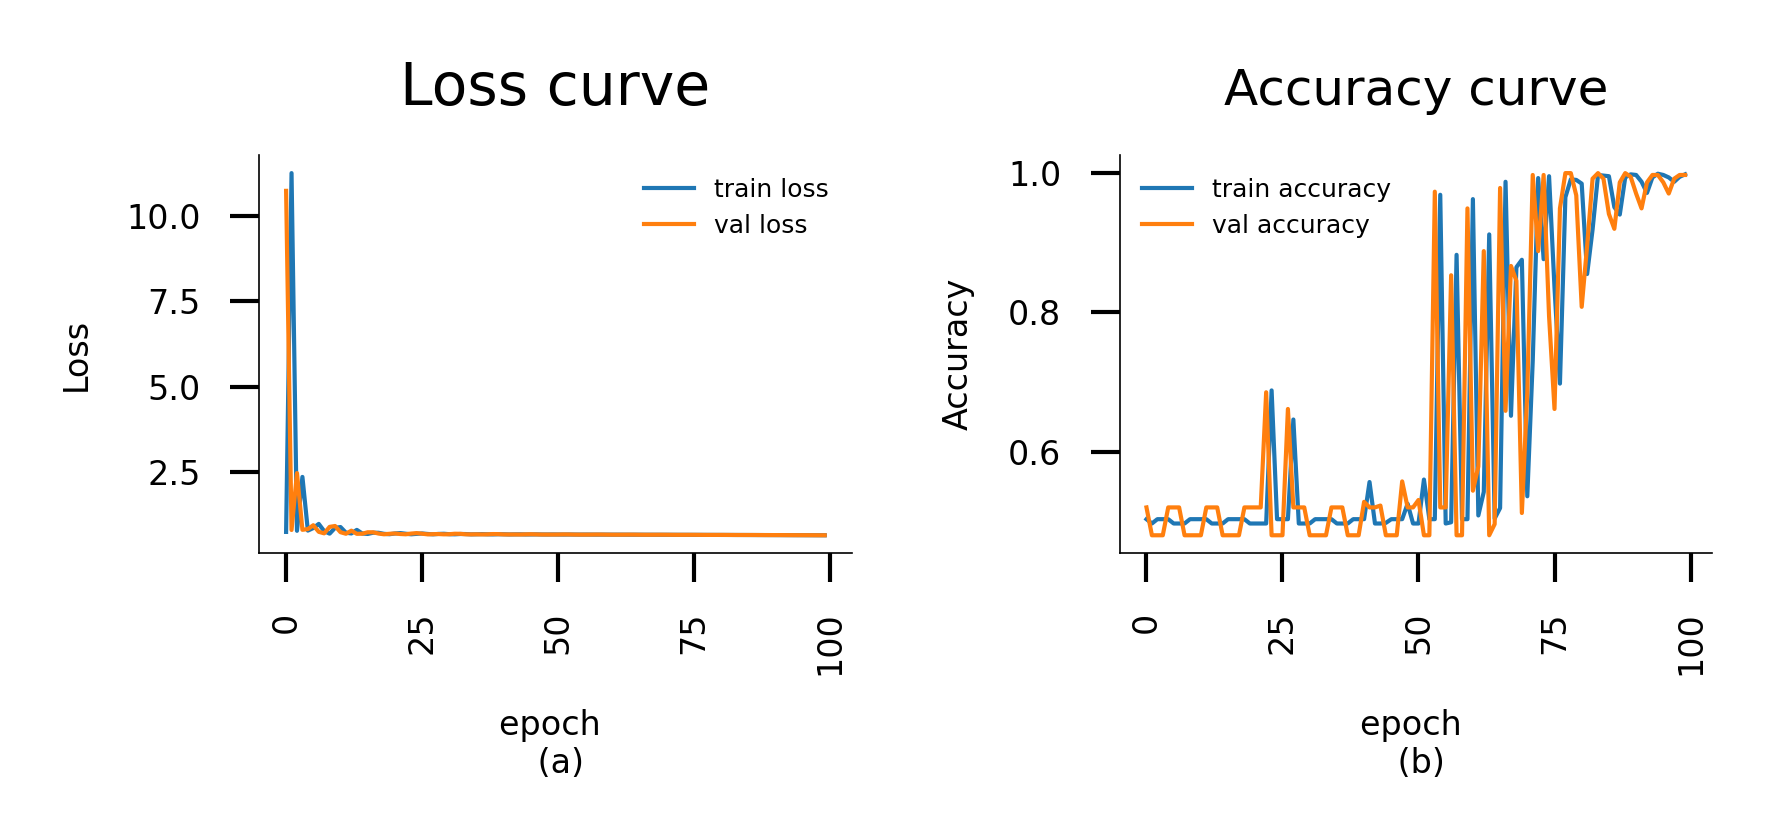

In [24]:
fig, ax= plt.subplots(1, 2, dpi =600, figsize = (3, 1.5))
ax[0].plot(history.history['loss'], label = "train loss", lw = 0.5)
ax[0].plot(history.history['val_loss'], label = "val loss", lw = 0.5)
ax[1].plot(history.history['accuracy'], label = "train accuracy", lw = 0.5)
ax[1].plot(history.history['val_accuracy'], label = "val accuracy", lw = 0.5)
ax[0].legend(fontsize=3, frameon=False)
ax[1].legend(fontsize=3, frameon=False)
ax[0].set_title("Loss curve", fontsize=7)
ax[1].set_title("Accuracy curve", fontsize=6)
ax[0].set_xlabel("epoch \n (a)", fontsize=6)
ax[1].set_xlabel("epoch \n (b)", fontsize=5)
ax[0].set_ylabel("Loss", fontsize=5)
ax[1].set_ylabel("Accuracy", fontsize=5)
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[0] = custom_figure_axis(ax[0], fontsize=4, show_ticks = True)
ax[1] = custom_figure_axis(ax[1], fontsize=4, show_ticks = True)
plt.tight_layout()
# plt.savefig("Motif curve.pdf", dpi = 600)

##### save the model

In [12]:
# model.save('fcgr_model.h5')
from keras.models import load_model
loaded_model = load_model('fcgr_model.h5')

2024-04-12 20:54:03.089687: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


##### Plot confusion matrix for test set

In [16]:
predicted_labels = loaded_model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 1s 32ms/step
Confusion matrix:
 [[258   1]
 [  0 241]]


In [22]:
# pd.Series(np.argmax(y_test, axis=1)).value_counts()

##### print test set metric

In [66]:
print("The accuracy of test set is ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The precision of test set is ",  precision_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The recall of test set is ", recall_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The f1 of test set is ",  f1_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The ROC_AUC of test set is ", roc_auc_score(np.argmax(y_test, axis=1), model.predict(X_test)[:, 1]))
print("The cohen kappa of test set is ", cohen_kappa_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))


The accuracy of test set is  0.998
The precision of test set is  0.9958677685950413
The recall of test set is  1.0
The f1 of test set is  0.9979296066252588
16/16 [==============================] - 0s 24ms/step
The ROC_AUC of test set is  1.0
The cohen kappa of test set is  0.9959953866854616
